<a href="https://colab.research.google.com/github/mpHarm88/DS-Unit-2-Regression-Classification/blob/master/module1/Mikio_Harman_assignment_regression_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 1

## Assignment

You'll use another **New York City** real estate dataset. 

But now you'll **predict how much it costs to rent an apartment**, instead of how much it costs to buy a condo.

The data comes from renthop.com, an apartment listing website.

- [ ] Look at the data. Choose a feature, and plot its relationship with the target.
- [ ] Use scikit-learn for linear regression with one feature. You can follow the [5-step process from Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Basics-of-the-API).
- [ ] Define a function to make new predictions and explain the model coefficient.
- [ ] Organize and comment your code.

> [Do Not Copy-Paste.](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit) You must type each of these exercises in, manually. If you copy and paste, you might as well not even do them. The point of these exercises is to train your hands, your brain, and your mind in how to read, write, and see code. If you copy-paste, you are cheating yourself out of the effectiveness of the lessons.

## Stretch Goals
- [ ] Do linear regression with two or more features.
- [ ] Read [The Discovery of Statistical Regression](https://priceonomics.com/the-discovery-of-statistical-regression/)
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 2.1: What Is Statistical Learning?

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module1')

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (156/156), 19.30 MiB | 14.55 MiB/s, done.
Resolving deltas: 100% (71/71), done.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 112kB 16.7MB/s 
     |████████████████████████████████| 133kB 36.8MB/s 
     |████████████████████████████████| 57.7MB 321kB/s 
     |████████████████████████████████| 235kB 36.4MB/s 
     |████████████████████████████████| 614kB 32.5MB/s 
     |████████████████████████████████| 235kB 35.9MB/s 
     |████████████████████████████████| 307kB 31.1MB/s 
     |████████████████████████████████| 215kB 44.8MB/s 
     |████████████████████████████████| 51kB 23.2MB/s 
     |█████████

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
# Read New York City apartment rental listing data
import pandas as pd
df = pd.read_csv('../data/apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

In [0]:
# Remove outliers: 
# the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= 1375) & (df['price'] <= 15500) & 
        (df['latitude'] >=40.57) & (df['latitude'] < 40.99) &
        (df['longitude'] >= -74.1) & (df['longitude'] <= -73.38)]

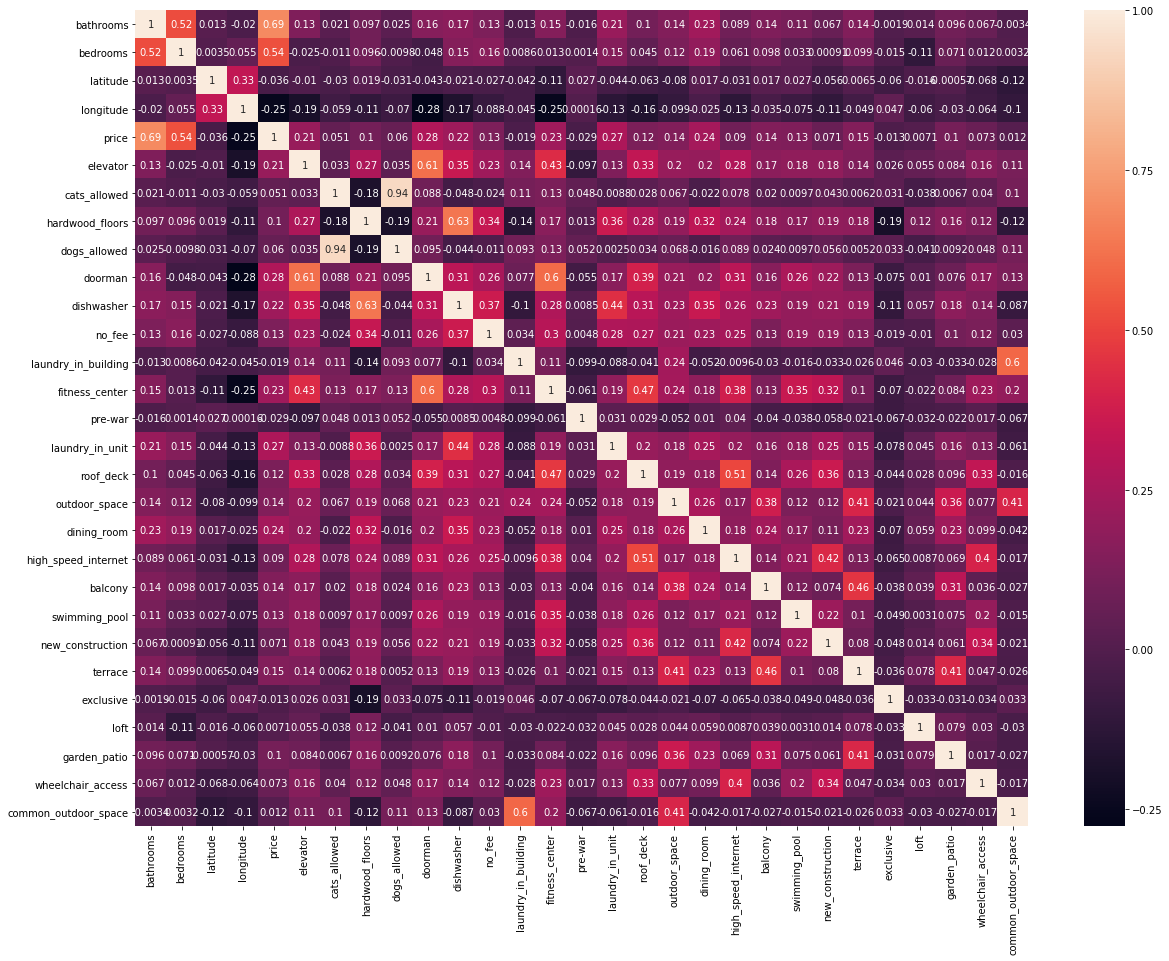

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

#Looking at the correlations
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True)

In [22]:
df.shape

(48818, 34)

In [23]:
from sklearn.linear_model import LinearRegression
import plotly.express as px

model = LinearRegression()

features = ['bathrooms']
target = 'price'
X_train = df[features]
y_train = df[target]

model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
#Fitting my line
px.scatter(df, x='bathrooms', y='price', trendline='ols')

In [26]:
#Creating a funcition that predicts the price based on how many bathrooms are present
def predict(x):
  m = model.coef_[0]
  b = model.intercept_
  y = (m*x)+b
  return y, m, b

predict(1)

(3060.278930599848, 2573.3743950844187, 486.9045355154294)

In [18]:
#Model with 2 features
model2 = LinearRegression()
features2 = ['bathrooms', 'bedrooms']
target2 = 'price'
X_train2 = df[features2]
y_train2 = df[target2]

model.fit(X_train2, y_train2)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

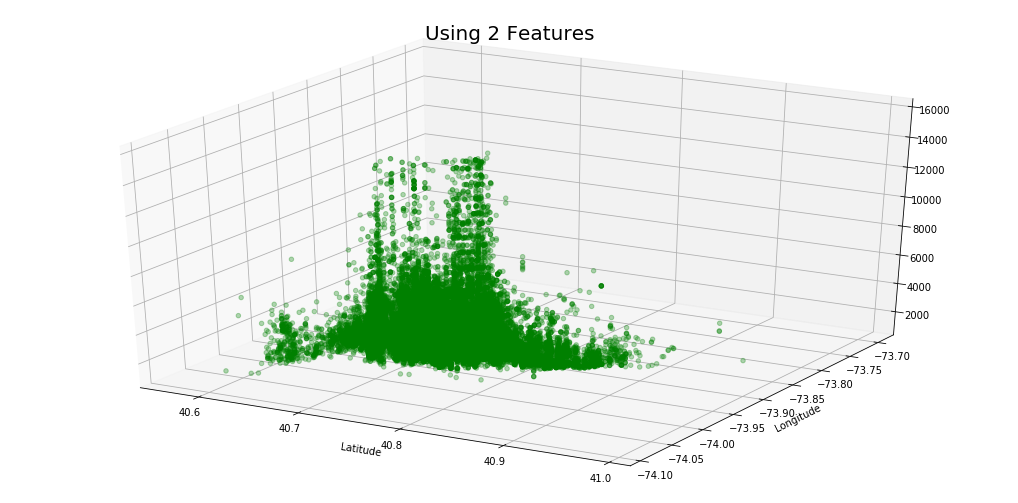

In [28]:
from mpl_toolkits.mplot3d import Axes3D
#Seeing relationship between longitude latitude and price

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( df[['latitude']], df[['longitude']],df[['price']],  color='green', alpha=.3)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Using 2 Features', fontsize=20)
plt.show()

###Going to try PCA

In [30]:
df.describe()

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
count,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.000000,48818.00000,48818.000000,48818.000000
mean,1.201790,1.537158,40.750756,-73.972758,3579.560982,0.524827,0.478266,0.478266,0.447622,0.424843,0.415072,0.367078,0.052767,0.268446,0.185649,0.175898,0.132758,0.138392,0.102831,0.087201,0.060469,0.055205,0.051907,0.046192,0.043304,0.042710,0.03933,0.027224,0.026240
std,0.470707,1.106078,0.038962,0.028887,1762.420875,0.499388,0.499533,0.499533,0.497254,0.494324,0.492740,0.482013,0.223571,0.443156,0.388827,0.380737,0.339317,0.345314,0.303741,0.282133,0.238357,0.228382,0.221842,0.209903,0.203542,0.202204,0.19438,0.162736,0.159851
min,0.000000,0.000000,40.571200,-74.087300,1375.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,1.000000,40.728300,-73.991800,2500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,1.000000,1.000000,40.751700,-73.978000,3150.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,2.000000,40.774000,-73.955000,4095.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,10.000000,8.000000,40.989400,-73.700100,15500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [31]:
df_num = df[['bathrooms', 	
            'bedrooms', 
            'latitude', 	
            'longitude' ,	
            'price', 			
            'elevator', 	
            'cats_allowed',
            'hardwood_floors',
            'dogs_allowed', 	
            'doorman',
            'dishwasher',
            'no_fee',
            'laundry_in_building',
            'fitness_center', 	
            'pre-war', 	
            'laundry_in_unit', 	
            'roof_deck', 	
            'outdoor_space', 	
            'dining_room', 	
            'high_speed_internet', 	
            'balcony', 	
            'swimming_pool', 	
            'new_construction', 	
            'terrace', 	
            'exclusive', 	
            'loft', 	
            'garden_patio', 	
            'wheelchair_access', 	
            'common_outdoor_space']].to_numpy()

df_num   

array([[ 1.5   ,  3.    , 40.7145, ...,  0.    ,  0.    ,  0.    ],
       [ 1.    ,  2.    , 40.7947, ...,  0.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    , 40.7388, ...,  0.    ,  0.    ,  0.    ],
       ...,
       [ 1.    ,  1.    , 40.7601, ...,  0.    ,  0.    ,  0.    ],
       [ 1.    ,  0.    , 40.7066, ...,  0.    ,  0.    ,  0.    ],
       [ 1.    ,  2.    , 40.8699, ...,  0.    ,  0.    ,  0.    ]])

In [0]:
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

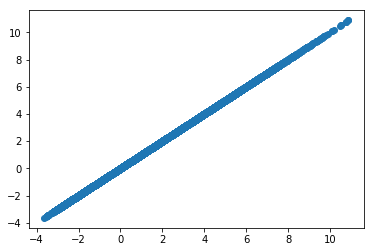

In [33]:
scaler = StandardScaler()
Z = scaler.fit_transform(df_num)

pca = PCA(2)
trans_data = pca.fit_transform(Z)

pc1 = trans_data[:,0]
pc2 = trans_data[:,1]


pca_df = pd.DataFrame({'pc1':pc1, 'pc2':pc2})
#Plotting 2 Principal Components
plt.scatter(x=pca_df['pc1'], y=pca_df['pc1'],)

plt.show()

In [34]:
pca_df.describe()

,pc1,pc2
count,4.881800e+04,4.881800e+04
mean,-1.235350e-16,-4.288247e-17
std,2.263421e+00,1.563462e+00
min,-3.632118e+00,-5.539306e+00
25%,-1.779366e+00,-1.068478e+00
50%,-6.131902e-01,-1.984958e-01
75%,1.152418e+00,9.485089e-01
max,1.087978e+01,7.109156e+00


Text(0.5, 0.92, 'Performing PCA')

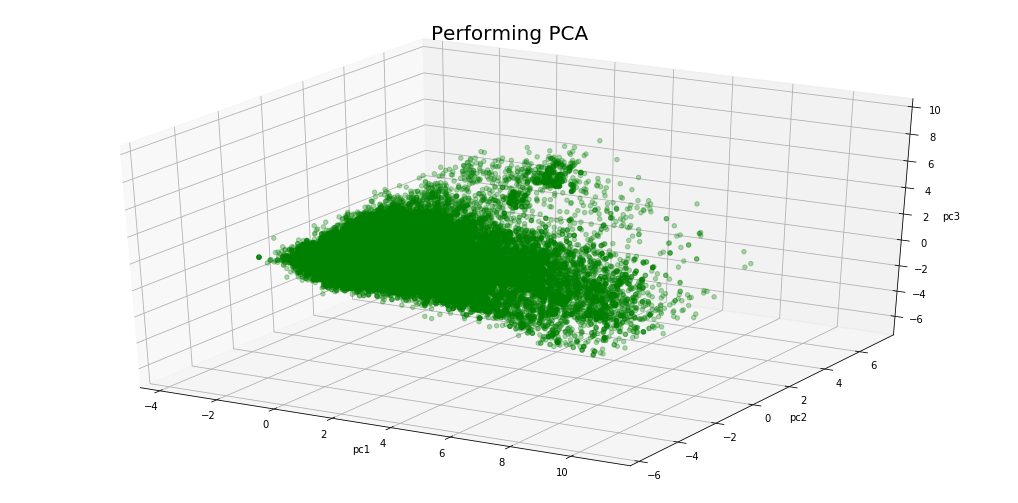

In [35]:
scaler = StandardScaler()
Z = scaler.fit_transform(df_num)

pca = PCA(3)
trans_data = pca.fit_transform(Z)

pc1 = trans_data[:,0]
pc2 = trans_data[:,1]
pc3 = trans_data[:,2]

pca_df = pd.DataFrame({'pc1':pc1, 'pc2':pc2, 'pc3':pc3})
#Plotting 3 components
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( pca_df[['pc1']], pca_df[['pc2']],pca_df[['pc3']],  color='green', alpha=.3)

plt.xlabel('pc1')
plt.ylabel('pc2')
ax.set_zlabel('pc3')
plt.title('Performing PCA', fontsize=20)

###Retrying PCA and Turning categorical features into cat codes


In [36]:
cat_col = df.columns[df.dtypes=='object']
num_col = df.columns[df.dtypes!='object']

#creating a df copy
df_processed = df
#changing d types to category
df_processed[cat_col] = df_processed[cat_col].astype('category')

df_processed.dtypes

bathrooms                float64
bedrooms                   int64
created                 category
description             category
display_address         category
latitude                 float64
longitude                float64
price                      int64
street_address          category
interest_level          category
elevator                   int64
cats_allowed               int64
hardwood_floors            int64
dogs_allowed               int64
doorman                    int64
dishwasher                 int64
no_fee                     int64
laundry_in_building        int64
fitness_center             int64
pre-war                    int64
laundry_in_unit            int64
roof_deck                  int64
outdoor_space              int64
dining_room                int64
high_speed_internet        int64
balcony                    int64
swimming_pool              int64
new_construction           int64
terrace                    int64
exclusive                  int64
loft      

In [37]:
#changing catgory types into their respective cat codes
for col in cat_col:
  df_processed[col] = df_processed[col].cat.codes

df_processed.shape

(48818, 34)

In [38]:
df_processed = scaler.fit_transform(df_processed)
df_processed

array([[ 0.63354155,  1.32256229,  1.54048699, ..., -0.20233614,
        -0.16728846, -0.16415673],
       [-0.42870022,  0.41845735,  1.05927155, ..., -0.20233614,
        -0.16728846, -0.16415673],
       [-0.42870022, -0.48564758, -1.10353652, ..., -0.20233614,
        -0.16728846, -0.16415673],
       ...,
       [-0.42870022, -0.48564758, -1.15331247, ..., -0.20233614,
        -0.16728846, -0.16415673],
       [-0.42870022, -1.38975252, -1.4845527 , ..., -0.20233614,
        -0.16728846, -0.16415673],
       [-0.42870022,  0.41845735, -1.34932325, ..., -0.20233614,
        -0.16728846, -0.16415673]])

In [0]:
import numpy as np
pca = PCA(10)
pca_features = pca.fit_transform(df)

In [0]:
# Define scree plot function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(9, 3))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

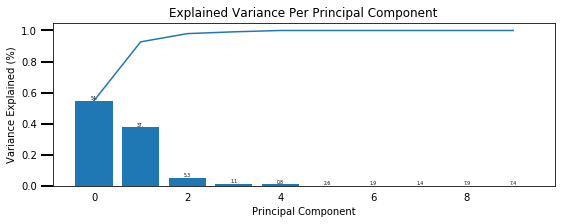

In [41]:
scree_plot(pca)